In [2]:
import os

import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import mediapipe as mp
import cv2
import pytube
from ffpyplayer.player import MediaPlayer

In [3]:
class JustDDance():
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_style = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    def __init__(self, const_k=0.6):
        self.__const_k = const_k
        self.__video_download_path = "video"
        self.__keypoints_path = "keypoints"
        self.__dance_name = None
        self.__accumulate_acc = []
    def set_const_k(self):
        self.__const_k = float(input("난이도 조절(0~1 사이 값): "))
    def get_const_k(self):
        print(f"현재 난이도: {self.__const_k}")
    def __get_accumlate_acc(self):
        return self.__accumulate_acc
    def __save_dance_name(self):
        self.__dance_name = input("누구의 무슨 춤?: 안유진 러브다이브")
    def set_dance_name(self, s):
        self.__dance_name = s
    def print_dance_data(self):
        acc_acc = self.__get_accumlate_acc()
        accMax, accMin, accMean = np.max(acc_acc), np.min(acc_acc), np.mean(acc_acc)
        print(f"Max Acc: {accMax}\tMin Acc: {accMin}\tAvg. Acc: {accMean}\n")
        acc_acc = pd.DataFrame(acc_acc)
        acc_acc.plot(figsize=(25, 6))
        plt.title("Accuarcy for Frames")
        plt.xlabel("Frames")
        plt.ylabel("Accuarcy")
        plt.legend("Acc")
        plt.axhline(y=70, color="r")
        plt.show()
    def download_video(self):
        self.__save_dance_name()
        url = input(f"{self.__dance_name}의 안무 영상 링크: ")
        if not os.path.exists(self.__video_download_path): os.mkdir(self.__video_download_path)
        yt = pytube.YouTube(url).streams.filter(res="720p").first()
        yt.download(output_path=self.__video_download_path, filename=self.__dance_name+".mp4")
    def __draw_skeleton(self, image, skeleton):
        # 오른쪽 스켈레톤 (붉은색)
        cv2.line(image, skeleton[12], skeleton[14], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/어깨 -> 오/팔꿈치
        cv2.line(image, skeleton[14], skeleton[16], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/팔꿈치 -> 오/손목
        cv2.line(image, skeleton[12], skeleton[24], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/어깨 -> 오/엉덩이
        cv2.line(image, skeleton[24], skeleton[26], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/엉덩이 -> 오/무릎
        cv2.line(image, skeleton[26], skeleton[28], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/무릎 -> 오/발목
        cv2.line(image, skeleton[28], skeleton[30], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오/발목 -> 오/뒷꿈치
        cv2.line(image, skeleton[30], skeleton[32], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오른발
        cv2.line(image, skeleton[28], skeleton[32], (102, 102, 255), thickness=7, lineType=cv2.LINE_AA, shift=None) # 오른발
        # 왼쪽 스켈레톤 (푸른색)
        cv2.line(image, skeleton[11], skeleton[13], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/어깨 -> 왼/팔꿈치
        cv2.line(image, skeleton[13], skeleton[15], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/팔꿈치 -> 왼/손목
        cv2.line(image, skeleton[11], skeleton[23], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/어깨 -> 왼/엉덩이
        cv2.line(image, skeleton[23], skeleton[25], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/엉덩이 -> 왼/무릎
        cv2.line(image, skeleton[25], skeleton[27], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/무릎 -> 왼/발목
        cv2.line(image, skeleton[27], skeleton[29], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼/발목 -> 왼/뒷꿈치
        cv2.line(image, skeleton[29], skeleton[31], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼발
        cv2.line(image, skeleton[27], skeleton[31], (255, 102, 102), thickness=7, lineType=cv2.LINE_AA, shift=None) # 왼발
        # 상체 스켈레톤 (회색)
        cv2.line(image, skeleton[11], skeleton[12], (224, 224, 224), thickness=5, lineType=cv2.LINE_AA, shift=None)
        cv2.line(image, skeleton[23], skeleton[24], (224, 224, 224), thickness=5, lineType=cv2.LINE_AA, shift=None)   
    def __get_margin(self, user_tri, dance_tri):
        margin = []
        ut = [(user_tri[0][0]+user_tri[1][0]+user_tri[2][0])/3, (user_tri[0][1]+user_tri[1][1]+user_tri[2][1])/3, (user_tri[0][2]+user_tri[1][2]+user_tri[2][2])/3]
        dt = [(dance_tri[0][0]+dance_tri[1][0]+dance_tri[2][0])/3, (dance_tri[0][1]+dance_tri[1][1]+dance_tri[2][1])/3, (dance_tri[0][2]+dance_tri[1][2]+dance_tri[2][2])/3]
        for u, d in zip(ut, dt): margin.append(u-d)
        return margin
    def __get_distance(self, pt1, pt2):
        return ((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)**0.5
    def __load_cor_data(self):
        with open(self.__keypoints_path+"/"+self.__dance_name+"_keypoints.json", "r") as keypoints:
            data = json.load(keypoints)
            return np.array(pd.DataFrame(data))
    def extract_keypoints(self, isMirr=False, showExtract=False):
        if not os.path.exists(self.__keypoints_path): os.mkdir(self.__keypoints_path)
        
        keypoint_dict_pose = []
        
        cv2.startWindowThread()
        cap = cv2.VideoCapture(os.path.join(self.__video_download_path, self.__dance_name+".mp4"))
        with self.mp_pose.Pose(model_complexity=2, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while cap.isOpened():
                ret, image = cap.read()
                if not ret: break
                if not isMirr: image = cv2.flip(image, 1)
                
                results = pose.process(image)
                # Extracting
                try: keypoint_dict_pose.append({str(idx): [lmk.x, lmk.y, lmk.z] for idx, lmk in enumerate(results.pose_landmarks.landmark)})
                except: pass
                if showExtract:
                    self.mp_drawing.draw_landmarks(image, results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS,
                                    landmark_drawing_spec=self.mp_drawing.DrawingSpec(color=(244, 244, 244), thickness=2, circle_radius=1),
                                    connection_drawing_spec=self.mp_drawing.DrawingSpec(color=(153, 255, 153), thickness=2, circle_radius=1))
                    cv2.imshow("Extracting", image)
                    if cv2.waitKey(1)==ord("q"): break
            cap.release()
            cv2.destroyAllWindows()
            cv2.waitKey(1)
        # Save coord. Data for json type
        with open(self.__keypoints_path+"/"+self.__dance_name+"_keypoints.json", "w") as keypoints:
            json.dump(keypoint_dict_pose, keypoints)
    def show_dance_tutorial(self):
        cv2.startWindowThread()
        dance = cv2.VideoCapture(os.path.join(self.__video_download_path, self.__dance_name+".mp4"))
        try: user = cv2.VideoCapture(0)
        except: user = cv2.VideoCapture(1)
        user.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
        user.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
        player = MediaPlayer(os.path.join(self.__video_download_path, self.__dance_name+".mp4"))
        dance_cors = self.__load_cor_data()
        dance_cors_frames = 0
        skeletons = {}
        pTime = 0
        FPS = dance.get(cv2.CAP_PROP_FPS)
        
        with self.mp_pose.Pose(model_complexity=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while user.isOpened():
                cTime = time.time()-pTime
                user_ret, user_image = user.read()
                dance_ret, dance_image = dance.read()
                if not user_ret: break
                if not dance_ret: break
                
                if cTime>1./FPS:
                    audio_frame, val = player.get_frame()
                    pTime = time.time()
                    acc_per_frame = []
                    user_image = cv2.cvtColor(cv2.flip(user_image, 1), cv2.COLOR_BGR2RGB)
                    user_results = pose.process(user_image)
                    user_image = cv2.cvtColor(user_image, cv2.COLOR_RGB2BGR)
                    # 사용자
                    # self.mp_drawing.draw_landmarks(user_image, user_results.pose_landmarks, self.mp_pose.POSE_CONNECTIONS,
                    #                             landmark_drawing_spec = self.mp_drawing.DrawingSpec(color=(244, 244, 244), thickness=2, circle_radius=1),
                    #                             connection_drawing_spec = self.mp_drawing.DrawingSpec(color=(153, 255, 153), thickness=2, circle_radius=1))
                    try:
                        user_input = {str(idx): [lmk.x, lmk.y, lmk.z] for idx, lmk in enumerate(user_results.pose_landmarks.landmark)}
                    except: pass
                    # 추출해 온 데이터
                    try:
                        # get coors MARGIN
                        cors_margin = self.__get_margin([user_input["0"], user_input["23"], user_input["24"]], [dance_cors[dance_cors_frames][0], dance_cors[dance_cors_frames][23], dance_cors[dance_cors_frames][24]])
                        for pose_point in [11, 12, 13, 14, 15, 16, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]:
                            x_cor_pose, y_cor_pose, z_cor_pose = int((dance_cors[dance_cors_frames][pose_point][0]+cors_margin[0])*user_image.shape[1]), int((dance_cors[dance_cors_frames][pose_point][1]+cors_margin[1])*user_image.shape[0]), int((dance_cors[dance_cors_frames][pose_point][2]+cors_margin[2])*1000)
                            cv2.circle(user_image, (x_cor_pose, y_cor_pose), 8, (244, 244, 244), cv2.FILLED)
                            skeletons[pose_point] = (x_cor_pose, y_cor_pose)
                            # L2 Norm
                            acc_per_frame.append(np.round(self.__const_k / (np.linalg.norm([(x_cor_pose/user_image.shape[1]-cors_margin[0])-user_input[str(pose_point)][0], (y_cor_pose/user_image.shape[0]-cors_margin[1])-user_input[str(pose_point)][1], (z_cor_pose/1000-cors_margin[2])-user_input[str(pose_point)][2]]) + self.__const_k), 2))
                            acc = np.mean(acc_per_frame)*100
                            self.__accumulate_acc.append(acc)
                        cv2.putText(user_image, str(acc)+"%", (20, 50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(0, 0, 255), thickness=2, lineType=cv2.LINE_AA)
                        self.__draw_skeleton(user_image, skeletons)
                        dance_cors_frames +=1
                    except: pass
                    h_output = np.hstack((cv2.flip(dance_image, 1), user_image))
                    cv2.imshow("Just DDance!", h_output)
                if cv2.waitKey(1)&0xFF==ord("q"): break
        player.close_player()
        user.release()
        dance.release()
        cv2.destroyAllWindows()
        cv2.waitKey(1)

In [4]:
jd = JustDDance()
jd.set_dance_name("이서 러브다이브")

In [4]:
jd.download_video()

In [ ]:
jd.extract_keypoints()

In [5]:
jd.show_dance_tutorial()

Max Acc: 85.0
Min Acc: 23.0
Avg. Acc: 55.28639701404971


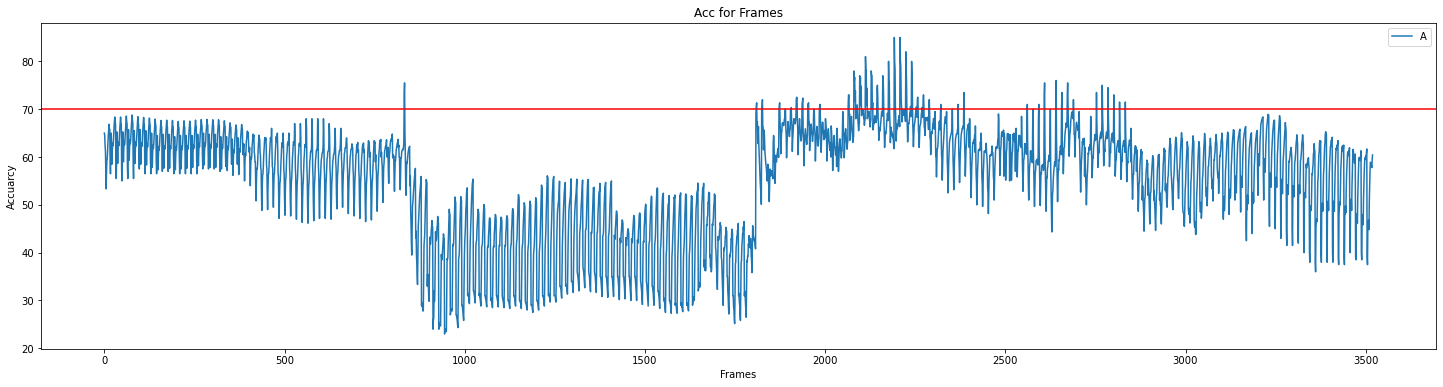

In [263]:
jd.print_dance_data()